In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2 
import albumentations as A
from albumentations.pytorch import ToTensorV2

import copy
import os
import random

# Подготовка данных

In [7]:
TRAIN_PATH = '/kaggle/input/tinkofftestccpd2019dl1/CCPD2019-dl1/train'
TEST_PATH = '/kaggle/input/tinkofftestccpd2019dl1/CCPD2019-dl1/test'

In [8]:
def get_label_chars_set():
    all_chars = set()
    for filename in os.listdir(TRAIN_PATH):
        label = filename.split('-')[-1][:-4]
        for char in label:
            all_chars.add(char)

    for filename in os.listdir(TEST_PATH):
        label = filename.split('-')[-1][:-4]
        for char in label:
            all_chars.add(char)
    return list(all_chars)

In [9]:
class CarNumsDataset(Dataset):
    def __init__(self, image_dir, image_names, transform=None):
        self.image_dir = image_dir
        self.image_names = image_names
        self.transform = transform
        self.label_chars_dict = {char : i for i, char in enumerate(get_label_chars_set())}
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_names[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.image_names[idx].split('-')[-1][:-4]
        label = self._transform_label(label)
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        return image, label
    
    def _transform_label(self, label):
        label_vector = [self.label_chars_dict[char] for char in label]
        return torch.tensor(label_vector, dtype=torch.long)

In [10]:
DATASET_MEAN = [0.2656, 0.4230, 0.6284]
DATASET_STD = [0.2096, 0.2029, 0.2181]

train_transform = A.Compose(
    [     
        A.PixelDropout(dropout_prob=0.05),
        A.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.01, rotate_limit=5, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.augmentations.geometric.Resize(128, 256),
        A.Normalize(mean=DATASET_MEAN, std=DATASET_STD),
        ToTensorV2()
    ]
)

val_transform = A.Compose(
    [
        A.augmentations.geometric.Resize(128, 256),
        A.Normalize(mean=DATASET_MEAN, std=DATASET_STD),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [
        A.augmentations.geometric.Resize(128, 256),
        A.Normalize(mean=DATASET_MEAN, std=DATASET_STD),
        ToTensorV2()
    ]
)

def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()


In [11]:
train_images = os.listdir(TRAIN_PATH)
train_images.sort()
random.seed(0)
random.shuffle(train_images) # for random train/val split further
test_images = os.listdir(TEST_PATH)
test_images.sort()

train_size = int(0.8 * len(train_images))
train_image_names = train_images[:train_size] 
val_image_names = train_images[train_size:]
test_image_names = test_images

train_dataset = CarNumsDataset(TRAIN_PATH, train_image_names, train_transform)
val_dataset = CarNumsDataset(TRAIN_PATH, val_image_names, val_transform)
test_dataset = CarNumsDataset(TEST_PATH, test_image_names, test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=256, num_workers=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=256)

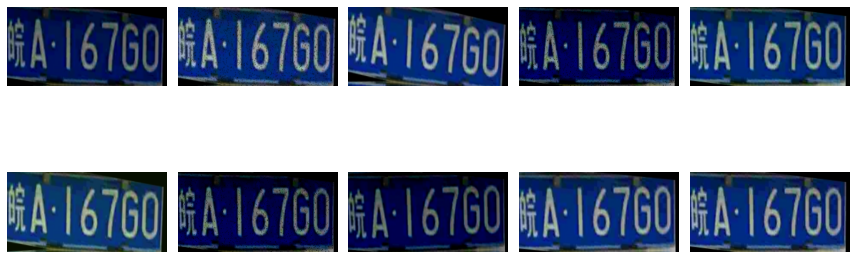

In [12]:
visualize_augmentations(train_dataset, 25)

# Создание и обучение модели

In [13]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [14]:
from torchvision.models import resnet18

In [31]:
class OCRModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.resnet = nn.Sequential(*list(resnet18(pretrained=False).children())[:-2])
        self.conv1 = nn.Conv1d(in_channels=512, out_channels=n_classes, kernel_size=2,
                               padding=0)    
    
    def forward(self, x):
        x = self.resnet(x)
        x = x.mean(dim=2)
        x = self.conv1(x)
        return x

In [18]:
def fit(epochs, model, optimizer, loss_fn):
    for epoch in range(1, epochs + 1):
        print(f'EPOCH_{epoch} START')
        
        train_loss = 0
        val_loss = 0
        train_acc = 0
        val_acc = 0
        train_cer = 0
        val_cer = 0
        
        model.train()
        for i, (xb, yb) in enumerate(train_dataloader):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            yb_logits = model(xb)

            loss = loss_fn(yb_logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            train_loss += loss.detach().cpu().item()
            yb_preds = yb_logits.argmax(dim=1) #[bs, 66 , 7] -> [bs, 7]
            acc = ((yb_preds == yb).all(dim=1)).float().mean()
            cer = (yb_preds != yb).float().mean()
            train_acc += acc.detach().cpu().item()
            train_cer += cer.detach().cpu().item()
            
            if i % 100 == 0:
                batch_num = i + 1
                avg_loss = train_loss / batch_num
                avg_acc = train_acc / batch_num
                avg_cer = train_cer / batch_num
                print(f'TRAIN_BATCH_NUM: {batch_num} TRAIN_LOSS: {avg_loss:.5f} TRAIN_ACC: {avg_acc:.5f} TRAIN_CER: {avg_cer:.5f}')     
                
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        train_cer /= len(train_dataloader)
        
        model.eval()
        with torch.inference_mode():    
            for xb, yb in val_dataloader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                yb_logits = model(xb)
                
                loss = loss_fn(yb_logits, yb)
                val_loss += loss.detach().cpu().item()
                yb_preds = yb_logits.argmax(dim=1)
                acc = ((yb_preds == yb).all(dim=1)).float().mean()
                cer = (yb_preds != yb).float().mean()
                val_acc += acc.detach().cpu().item()
                val_cer += cer.detach().cpu().item()                
        
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        val_cer /= len(val_dataloader)
         
        print(f'EPOCH_{epoch} END')
        print(f'TRAIN_LOSS: {train_loss:.5f} TRAIN_ACC: {train_acc:.5f} TRAIN_CER: {train_cer:.5f}')
        print(f'VAL_LOSS:   {val_loss:.5f} VAL_ACC:   {val_acc:.5f} VAL_CER:   {val_cer:.5f}')
        print('-'*50)

In [19]:
n_classes = len(get_label_chars_set())
model = OCRModel(n_classes=n_classes)
model.to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [20]:
fit(epochs, model, optimizer, loss_fn)

EPOCH_1 START
TRAIN_BATCH_NUM: 1 TRAIN_LOSS: 4.35284 TRAIN_ACC: 0.00000 TRAIN_CER: 0.99442
TRAIN_BATCH_NUM: 101 TRAIN_LOSS: 0.35784 TRAIN_ACC: 0.73886 TRAIN_CER: 0.08341
TRAIN_BATCH_NUM: 201 TRAIN_LOSS: 0.19191 TRAIN_ACC: 0.85236 TRAIN_CER: 0.04463
TRAIN_BATCH_NUM: 301 TRAIN_LOSS: 0.13290 TRAIN_ACC: 0.89458 TRAIN_CER: 0.03089
TRAIN_BATCH_NUM: 401 TRAIN_LOSS: 0.10294 TRAIN_ACC: 0.91628 TRAIN_CER: 0.02394
TRAIN_BATCH_NUM: 501 TRAIN_LOSS: 0.08390 TRAIN_ACC: 0.93062 TRAIN_CER: 0.01953
TRAIN_BATCH_NUM: 601 TRAIN_LOSS: 0.07137 TRAIN_ACC: 0.93981 TRAIN_CER: 0.01664
EPOCH_1 END
TRAIN_LOSS: 0.06890 TRAIN_ACC: 0.94176 TRAIN_CER: 0.01606
VAL_LOSS:   0.00444 VAL_ACC:   0.99341 VAL_CER:   0.00101
--------------------------------------------------
EPOCH_2 START
TRAIN_BATCH_NUM: 1 TRAIN_LOSS: 0.00630 TRAIN_ACC: 0.99219 TRAIN_CER: 0.00112
TRAIN_BATCH_NUM: 101 TRAIN_LOSS: 0.00632 TRAIN_ACC: 0.99022 TRAIN_CER: 0.00161
TRAIN_BATCH_NUM: 201 TRAIN_LOSS: 0.00565 TRAIN_ACC: 0.99083 TRAIN_CER: 0.00149
TRAIN_B

In [21]:
torch.save(model.state_dict(), 'model_10_epochs.pt')

# Подсчет метрик

In [20]:
def get_model_predictions(model, dataloader):
    preds = []
    model.eval()
    for xb, yb in dataloader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        yb_logits = model(xb)
        yb_preds = yb_logits.argmax(dim=1)
        preds.append(yb_preds)
    return torch.concat(preds)

def get_all_target(dataset):
    dataloader = DataLoader(dataset, batch_size=len(dataset))
    xb, yb = next(iter(dataloader))
    yb = yb.to(DEVICE)
    return yb

In [21]:
test_target = get_all_target(test_dataset)
test_preds = get_model_predictions(model, test_dataloader)

**МЕТРИКИ**

In [34]:
test_acc = (test_target == test_preds).all(dim=1).float().mean().item()
test_cer = (test_target != test_preds).float().mean().item()
print(f'TEST_ACC: {test_acc:.5f} TEST_CER: {test_cer:.4f}')

TEST_ACC: 0.98280 TEST_CER: 0.0028


# Анализ ошибок

In [53]:
wrong_preds_idx = (~((test_target == test_preds).all(dim=1)))
wrong_preds_idx = wrong_preds_idx.nonzero().squeeze().cpu().numpy()
wrong_preds_idx

array([   8,   44,   71,   94,  140,  161,  239,  438,  465,  483,  507,
        575,  627,  688,  714,  735,  737,  775,  890, 1021, 1028, 1064,
       1182, 1251, 1380, 1489, 1655, 1694, 1860, 1882, 2004, 2028, 2087,
       2177, 2274, 2279, 2351, 2612, 2775, 2815, 2816, 3005, 3017, 3075,
       3102, 3239, 3313, 3338, 3399, 3483, 3484, 3518, 3571, 3578, 3650,
       3806, 3819, 3886, 3894, 3925, 3941, 3978, 4037, 4145, 4206, 4298,
       4320, 4328, 4417, 4515, 4526, 4664, 4774, 4822, 4908, 5038, 5107,
       5226, 5231, 5249, 5369, 5446, 5604, 5655, 5781, 5825, 5838, 5854,
       5912, 5942, 6091, 6109, 6177, 6215, 6432, 6456, 6489, 6520, 6524,
       6557, 6562, 6706, 6721, 6803, 6968, 6974, 6992, 7096, 7233, 7276,
       7321, 7398, 7422, 7440, 7544, 7564, 7767, 7826, 7865, 7966, 7977,
       7980, 8020, 8096, 8105, 8125, 8194, 8202, 8274, 8353, 8370, 8375,
       8410, 8477, 8513, 8520, 8601, 8712, 8713, 8759, 8848, 8931, 8946,
       8997, 9062, 9122, 9155, 9174, 9208, 9213, 92

In [56]:
def plot_images(dataset, ids, cols):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = len(ids) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 12))
    for i, idx in enumerate(ids):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

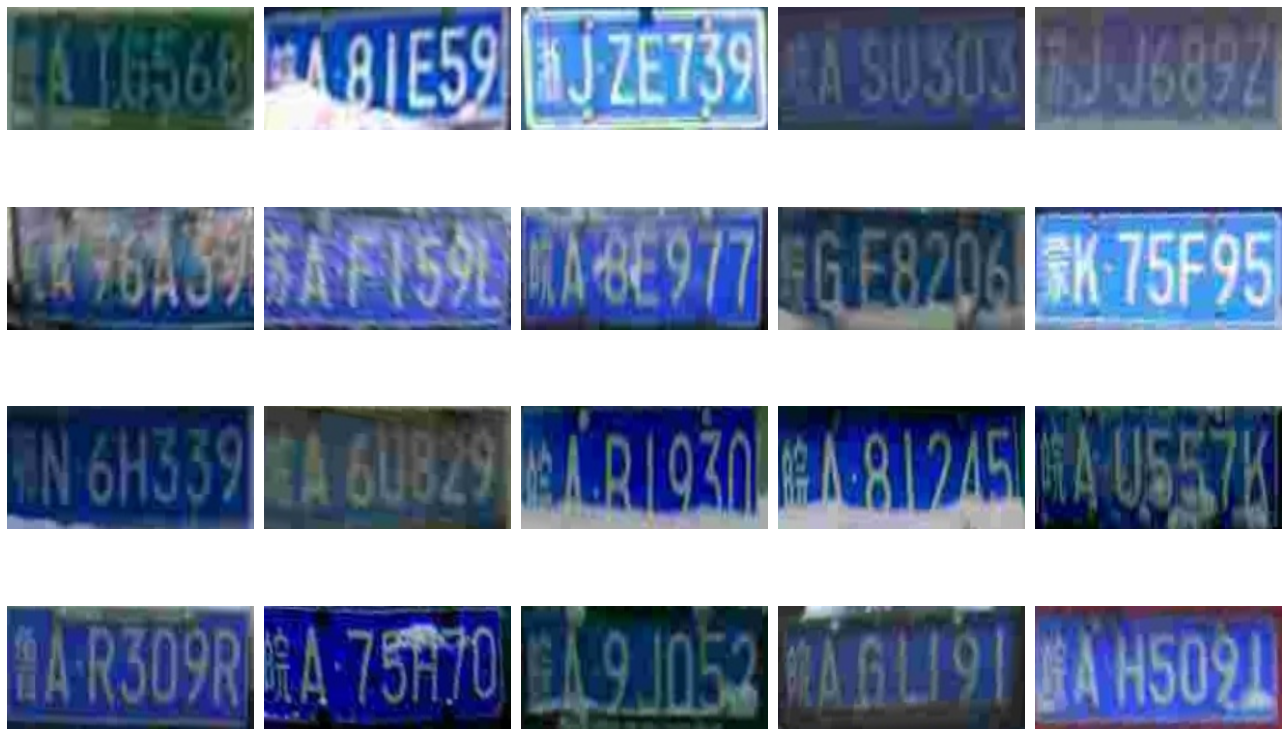

In [58]:
plot_images(test_dataset, wrong_preds_idx[:20], 5)

<font size=3>
    В большинстве картинок на которых ошиблась модель качество изображения такое, что даже человеку сложно разобрать какой именно номер (в особенности иероглиф) изображен на картинке 
<\font>